<a href="https://colab.research.google.com/github/Judeeme/Real-time-Sleep-Apnoea-Project/blob/main/Training_10453_1153.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.2 MB/s eta 0:00:00


In [4]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
edf_path = r"/content/sample_data/10453_1153.edf"
ann_path = r"/content/sample_data/10453_1153.annot"   # or .annots
tsv_path = r"/content/sample_data/10453_1153.tsv"

In [8]:
raw = mne.io.read_raw_edf(edf_path, preload=True)
print("Channels in EDF file:")
print(raw.ch_names)

Extracting EDF parameters from /content/sample_data/10453_1153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-419204978.py:1: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Reading 0 ... 1411071  =      0.000 ...  5511.996 secs...
Channels in EDF file:
['Patient Event', 'EOG LOC-M2', 'EOG ROC-M1', 'EMG Chin1-Chin2', 'EEG F3-M2', 'EEG F4-M1', 'EEG C3-M2', 'EEG C4-M1', 'EEG O1-M2', 'EEG O2-M1', 'EEG CZ-O1', 'EMG LLeg-RLeg', 'ECG EKG2-EKG', 'Snore', 'Resp PTAF', 'Resp Airflow', 'Resp Thoracic', 'Resp Abdominal', 'SpO2', 'Rate', 'EtCO2', 'Capno', 'Resp Rate', 'C-flow', 'Tidal Vol', 'Pressure']


In [16]:
try:
    # Try reading annotations from the .annot file (original approach)
    annotations = mne.read_annotations(ann_path)
    raw.set_annotations(annotations)
    print("EDF annotations successfully loaded and linked from .annot file!")
except Exception as e:
    print(f"Could not load .annotations file: {e}")
    print("Attempting to create annotations from .tsv data...")
    try:
        # Create annotations from the tsv_data DataFrame
        annotations_from_tsv = mne.Annotations(
            onset=tsv_data['onset'],
            duration=tsv_data['duration'],
            description=tsv_data['description']
        )
        raw.set_annotations(annotations_from_tsv)
        print("Annotations successfully created and linked from .tsv data!")
    except Exception as tsv_e:
        print(f"Could not create annotations from .tsv data: {tsv_e}")

Could not load .annotations file: Unknown annotation file format "/content/sample_data/10453_1153.annot"
Attempting to create annotations from .tsv data...
Annotations successfully created and linked from .tsv data!


/tmp/ipython-input-2501461872.py:16: RuntimeWarning: Omitted 919 annotation(s) that were outside data range.
  raw.set_annotations(annotations_from_tsv)
/tmp/ipython-input-2501461872.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations_from_tsv)


In [17]:
tsv_data = pd.read_csv(tsv_path, sep='\t')
print(tsv_data.head())

       onset  duration                       description
0   0.929688       0.0            Started Analyzer - ECG
1   1.347656       0.0                Video Recording ON
2  35.558594       0.0  Montage:Channel Test Referential
3  35.558594       0.0  Montage:Channel Test Referential
4  95.914062       0.0          Montage:NCH_PSG_STANDARD


In [11]:
# Print the info of the raw data to see its time range
print(raw.info)

# Print the min and max onset times from the tsv data
print("\nMin onset time in tsv data:", tsv_data['onset'].min())
print("Max onset time in tsv data:", tsv_data['onset'].max())

<Info | 8 non-empty values
 bads: []
 ch_names: Patient Event, EOG LOC-M2, EOG ROC-M1, EMG Chin1-Chin2, EEG ...
 chs: 26 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 21:04:51 UTC
 nchan: 26
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: 0000000, sex: 0, last_name: XXXXX,XXXX, birthday: 2001-01-01>
>

Min onset time in tsv data: 0.9296875
Max onset time in tsv data: 31440.25390625


In [12]:
spo2_channel = [ch for ch in raw.ch_names if "spo2" in ch.lower() or "ox" in ch.lower()][0]
spo2_data, times = raw.copy().pick_channels([spo2_channel]).get_data(return_times=True)
spo2_data = spo2_data[0]
print(f"Extracted {spo2_channel} signal with {len(spo2_data)} samples.")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracted SpO2 signal with 1411072 samples.


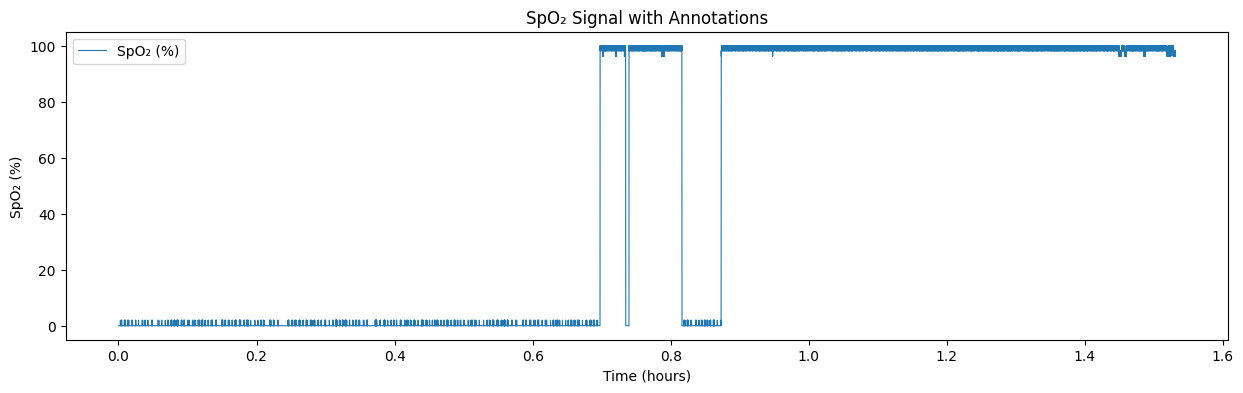

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(times / 3600, spo2_data, label="SpO₂ (%)", linewidth=0.8)
plt.xlabel("Time (hours)")
plt.ylabel("SpO₂ (%)")
plt.title("SpO₂ Signal with Annotations")
plt.legend()
plt.show()

In [14]:
df = pd.DataFrame({"time_sec": times, "spo2": spo2_data})
df.to_csv("extracted_spo2_signal.csv", index=False)
print("SpO₂ data exported to extracted_spo2_signal.csv ✅")

SpO₂ data exported to extracted_spo2_signal.csv ✅


In [15]:
apnea_events = []
for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
    if "apnea" in desc.lower() or "hypopnea" in desc.lower():
        apnea_events.append({"start": onset, "end": onset + duration, "label": desc})
print(f"Detected {len(apnea_events)} apnea/hypopnea events")

Detected 0 apnea/hypopnea events


In [18]:
apnea_events = []
for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
    if "apnea" in desc.lower() or "hypopnea" in desc.lower():
        apnea_events.append({"start": onset, "end": onset + duration, "label": desc})
print(f"Detected {len(apnea_events)} apnea/hypopnea events")

Detected 1 apnea/hypopnea events


In [19]:
apnea_mask = np.zeros_like(times)
for event in apnea_events:
    apnea_mask[(times >= event["start"]) & (times <= event["end"])] = 1

In [20]:
spo2_data = np.clip(spo2_data, 70, 100)  # physiological range
spo2_data = medfilt(spo2_data, kernel_size=5)

In [22]:
factor = int(raw.info['sfreq'])
spo2_ds = spo2_data[::factor]
time_ds = times[::factor]
apnea_mask_ds = apnea_mask[::factor]

print(f"Downsampled from {len(spo2_data)} → {len(spo2_ds)} points")

Downsampled from 1411072 → 5512 points


In [23]:
window_size = 30  # seconds
step = 10  # seconds
samples_per_window = int(window_size)
step_size = int(step)

features = []
labels = []

for start in range(0, len(spo2_ds) - samples_per_window, step_size):
    end = start + samples_per_window
    segment = spo2_ds[start:end]
    label = int(np.mean(apnea_mask_ds[start:end]) > 0.5)

    mean_val = np.mean(segment)
    std_val = np.std(segment)
    min_val = np.min(segment)
    max_val = np.max(segment)
    range_val = max_val - min_val
    drop_val = mean_val - min_val
    slope = (segment[-1] - segment[0]) / window_size

    features.append([mean_val, std_val, min_val, max_val, range_val, drop_val, slope])
    labels.append(label)

feature_names = ["mean", "std", "min", "max", "range", "drop", "slope"]
X = np.array(features)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}, Labels: {np.bincount(y)}")


Feature matrix shape: (549, 7), Labels: [549]


In [25]:
# Create the DataFrame from features and feature names
df_features = pd.DataFrame(X, columns=feature_names)

# Add the label as a column
df_features['label'] = y

# Display the first 10 rows
print("\n--- Feature DataFrame (First 10 Rows) ---")
display(df_features.head(10))


--- Feature DataFrame (First 10 Rows) ---


,mean,std,min,max,range,drop,slope,label
0,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
1,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
2,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
3,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
4,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
5,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
6,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
7,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
8,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0
9,70.0,0.0,70.0,70.0,0.0,0.0,0.0,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [28]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Confusion Matrix:")
# Provide only the labels present in the test set to confusion_matrix
print(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)))
print("\nClassification Report:")
# Provide only the labels present in the test set to classification_report
print(classification_report(y_test, y_pred, target_names=["Normal"], labels=[0]))

# Note: The classification report only shows results for the 'Normal' class
# because no 'Apnea' events were present in the test set (or the training set based on the feature extraction).
# This likely indicates an issue with the annotation extraction or feature labeling process
# if you expected to have both classes.


Model Performance:
Accuracy: 1.000
Confusion Matrix:
[[110]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       110

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


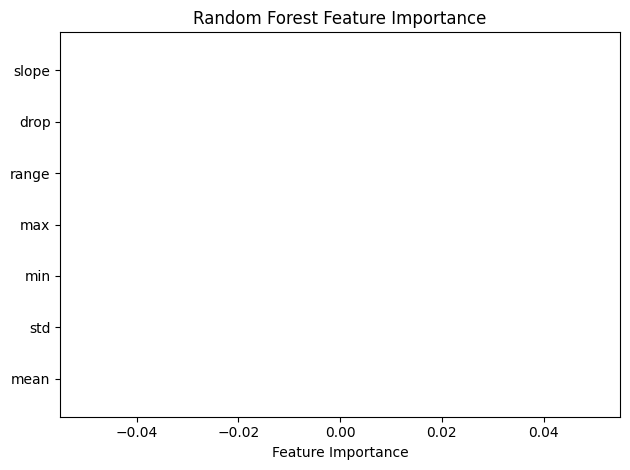

In [29]:
importances = clf.feature_importances_
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [30]:
results = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
results.to_csv("feature_importance_spo2_apnea.csv", index=False)